# Notebook de Modelaje: Clasificación temprana Huracán (Clase 1)

Este notebook implementa un **pipeline completo** para:

1. **Cargar y preparar** el dataset (variables ambientales).
2. Definir un **preprocesamiento** (escalado numérico + one-hot de categóricas) dentro de un `Pipeline`.
3. Ejecutar una **suite de búsqueda de hiperparámetros** por modelo (`Grid`, `Random`, `Coarse-to-Fine`, `Halving`, `Bayes`.
4. Re-entrenar cada modelo con sus mejores hiperparámetros en **TRAIN** y evaluar en **TEST** con métricas enfocadas en la **clase 1** (huracán).
5. Seleccionar el **modelo final** para el paper usando **CV** con hiperparámetros del punto 4.
6. Visualizaciones y matrices.

> **Objetivo:** minimizar **FN** (no detectar huracanes), priorizando **Recall de clase 1** y controlando el trade-off vía **threshold**.

# 1) Importaciones

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import (
    precision_score, recall_score, fbeta_score, average_precision_score,
    confusion_matrix, make_scorer
)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.base import clone
from sklearn.model_selection import ParameterSampler, cross_val_score

from scipy.stats import randint, uniform, loguniform

# Modelos
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression





SKOPT_OK = True
try:
    from skopt import BayesSearchCV
    from skopt.space import Integer, Real, Categorical
except Exception:
    SKOPT_OK = False


from joblib import Parallel, delayed
from sklearn.metrics import precision_recall_curve, confusion_matrix, average_precision_score
# Para capturar error de parámetros
from sklearn.utils._param_validation import InvalidParameterError


import ast
import joblib

# 2) Carga de datos

In [238]:
import os
os.chdir(r"E:\PROMIDAT\Maestria\Proyecto\project\data\processed")
datos = pd.read_csv("dataset_final_completo.csv", delimiter = ',', decimal = ".",index_col=0)

datos.drop(columns=["year", "month", "day","hour","lat","lon"], inplace=True)

datos

,label,u200,v200,u850,v850,shear_200_850,rh600_700,t500,tcwv,sst_c,mslp_hpa,nino34_anom,romi1,romi2,amo_ssta,nao_index,qbo_30mb
id,,,,,,,,,,,,,,,,,
AL162000,0,18.137482,-8.176942,7.164326,-11.838987,11.568091,69.531734,247.843399,13.303246,13.369470,974.825625,-0.71,-1.78350,1.96727,0.20,0.9200,-14.04
AL172024,0,5.365496,19.808054,4.972994,0.130060,19.681908,47.393650,254.175476,19.947849,21.953271,999.724687,-0.28,-0.80061,1.41531,1.25,-0.3750,11.64
AL242020,0,-0.863598,5.844433,0.225705,-6.553730,12.445924,56.553829,253.366043,20.769268,17.614771,1006.584062,-0.64,-0.80712,1.43512,0.71,0.9850,7.95
AL012023,0,6.547538,14.877802,7.908930,11.739385,3.420972,66.199057,253.244293,21.953262,16.906854,996.786016,-0.69,0.17468,0.69994,0.76,1.2503,12.50
AL192019,0,9.083817,2.021300,8.850555,-1.652135,3.680834,72.003357,254.559006,22.067078,20.567438,981.025938,0.52,-1.06084,1.21611,0.66,-1.4134,7.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL171995,1,-1.209954,-2.141801,1.686205,-0.744938,3.215425,87.124622,270.185394,64.053238,29.487726,1001.496484,-0.94,0.13930,0.22923,0.28,0.1900,3.43
AL092024,1,1.923334,7.262951,-4.011394,3.799496,6.871428,84.023098,269.376862,64.178864,30.545465,1006.270625,-0.15,0.56549,0.81475,1.22,-1.4283,10.36
AL012024,0,-5.921295,-4.912003,-1.094237,2.529239,8.869755,83.328621,270.979858,65.293816,29.583551,1000.645859,0.24,-0.02442,0.12463,1.39,-0.0865,1.95


# 3) Inspección rápida del dataset

In [239]:


datos.info()



<class 'pandas.core.frame.DataFrame'>
Index: 563 entries, AL162000 to AL061998
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   label          563 non-null    int64  
 1   u200           563 non-null    float64
 2   v200           563 non-null    float64
 3   u850           563 non-null    float64
 4   v850           563 non-null    float64
 5   shear_200_850  563 non-null    float64
 6   rh600_700      563 non-null    float64
 7   t500           563 non-null    float64
 8   tcwv           563 non-null    float64
 9   sst_c          563 non-null    float64
 10  mslp_hpa       563 non-null    float64
 11  nino34_anom    563 non-null    float64
 12  romi1          563 non-null    float64
 13  romi2          563 non-null    float64
 14  amo_ssta       563 non-null    float64
 15  nao_index      563 non-null    float64
 16  qbo_30mb       563 non-null    float64
dtypes: float64(16), int64(1)
memory usage: 79.2+ KB

In [240]:
datos['label'].value_counts(True)

label
0    0.55595
1    0.44405
Name: proportion, dtype: float64

## Resumen descriptivos

In [ ]:
#import pandas as pd
#import numpy as np
#import seaborn as sns
#import matplotlib.pyplot as plt

# =========================
# 1) Resumen estadístico + missing
# =========================


def resumen_estadistico_basico(datos, target_col="label"):
    df = datos.drop(columns=[target_col])
    desc = df.describe().T
    desc["missing_%"] = df.isna().mean() * 100

    cols = ["count", "mean", "std", "min", "25%", "50%", "75%", "max", "missing_%"]
    return desc[cols]

# USO:
resumen_basico = resumen_estadistico_basico(datos, target_col="label")
print(resumen_basico.to_string())



               count         mean        std         min          25%          50%          75%          max  missing_%
u200           563.0     0.664121   8.027889  -19.970457    -5.055155    -0.738509     5.332851    35.633938        0.0
v200           563.0     3.354884   6.461340  -18.711727    -0.402337     2.370100     6.863261    30.912838        0.0
u850           563.0    -2.184862   4.247283  -12.430018    -4.934662    -2.501513    -0.028539    15.150890        0.0
v850           563.0     2.543226   2.956884  -11.838987     0.856309     2.463674     4.335046    15.195911        0.0
shear_200_850  563.0     7.758530   5.580234    0.353639     3.917276     6.498609     9.683983    43.415899        0.0
rh600_700      563.0    73.667473   9.576747   39.463408    67.516405    75.015507    80.949158    92.115658        0.0
t500           563.0   267.113592   2.488885  247.843399   266.707123   267.731995   268.380035   270.979858        0.0
tcwv           563.0    52.223866   7.79

## Correlación

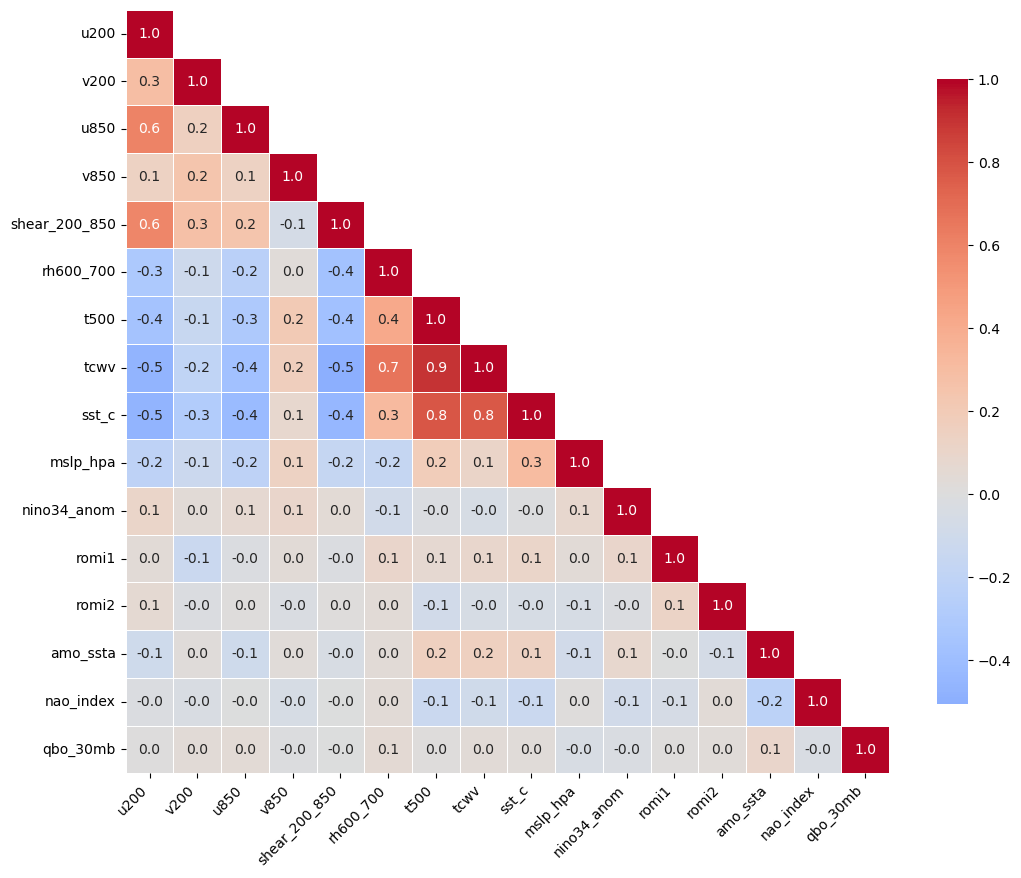

,u200,v200,u850,v850,shear_200_850,rh600_700,t500,tcwv,sst_c,mslp_hpa,nino34_anom,romi1,romi2,amo_ssta,nao_index,qbo_30mb
u200,1.000000,0.293370,0.600640,0.140393,0.586672,-0.317007,-0.360999,-0.475244,-0.465105,-0.212522,0.101365,0.029530,0.060260,-0.102284,-0.019109,0.004960
v200,0.293370,1.000000,0.156083,0.245192,0.277373,-0.107404,-0.149159,-0.198713,-0.287703,-0.124036,0.039115,-0.131856,-0.016836,0.022688,-0.031557,0.037877
u850,0.600640,0.156083,1.000000,0.135765,0.242979,-0.238305,-0.301946,-0.374635,-0.420191,-0.212413,0.065709,-0.019887,0.007663,-0.100792,-0.004296,0.043017
v850,0.140393,0.245192,0.135765,1.000000,-0.059554,0.026853,0.206795,0.167564,0.083293,0.140309,0.096509,0.032103,-0.024129,0.025885,-0.049680,-0.006350
shear_200_850,0.586672,0.277373,0.242979,-0.059554,1.000000,-0.367802,-0.378180,-0.505820,-0.446390,-0.167695,0.045377,-0.018442,0.012254,-0.039945,-0.003802,-0.002553
rh600_700,-0.317007,-0.107404,-0.238305,0.026853,-0.367802,1.000000,0.420547,0.665656,0.316009,-0.170429,-0.089528,0.096996,0.040585,0.038626,0.030337,0.051556
t500,-0.360999,-0.149159,-0.301946,0.206795,-0.378180,0.420547,1.000000,0.904648,0.779747,0.185265,-0.020636,0.068397,-0.087344,0.154851,-0.140457,0.013906
tcwv,-0.475244,-0.198713,-0.374635,0.167564,-0.505820,0.665656,0.904648,1.000000,0.774706,0.117406,-0.047841,0.088430,-0.048456,0.155229,-0.098006,0.030078
sst_c,-0.465105,-0.287703,-0.420191,0.083293,-0.446390,0.316009,0.779747,0.774706,1.000000,0.310801,-0.008515,0.101488,-0.048195,0.146795,-0.133372,0.025546
mslp_hpa,-0.212522,-0.124036,-0.212413,0.140309,-0.167695,-0.170429,0.185265,0.117406,0.310801,1.000000,0.086369,0.032264,-0.050410,-0.082763,0.017535,-0.036154


In [ ]:


# =========================
# 4) Heatmap de correlación
# =========================
def heatmap_correlacion(datos, target_col="label"):
    df = datos.drop(columns=[target_col])
    corr = df.corr()

    # máscara: ocultar solo el triángulo superior (dejando la diagonal)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

    plt.figure(figsize=(11, 9))
    ax = sns.heatmap(
        corr,
        mask=mask,
        cmap="coolwarm",
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        annot=True,
        fmt=".1f"
    )

    #ax.set_title("Matriz de correlación (triángulo inferior + diagonal)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

    plt.tight_layout()
    plt.savefig("heatmap_correlacion.png", dpi=300, bbox_inches='tight')
    plt.show()




# USO:
heatmap_correlacion(datos, target_col="label")
df = datos.drop(columns=["label"])
corr = df.corr()
corr






## Distribución variable huracán

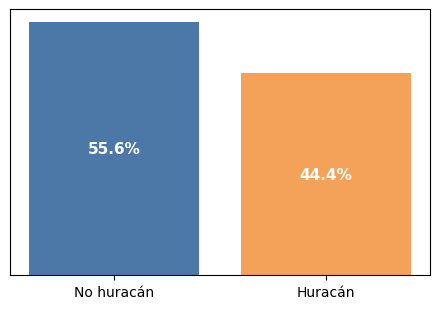

In [282]:


def distribucion_label(datos, target_col="label"):
    counts = datos[target_col].value_counts().sort_index()
    props = datos[target_col].value_counts(normalize=True).sort_index()

    labels = ["No huracán", "Huracán"]
    colors = ["#4c78a8", "#f4a259"]  # azul, naranja

    plt.figure(figsize=(4.5, 3.2))
    bars = plt.bar(labels, counts.values, color=colors, edgecolor="none")

    # porcentaje centrado dentro de la barra
    for bar, p in zip(bars, props.values):
        plt.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height()/2,
            f"{p*100:.1f}%",
            ha="center", va="center",
            color="white", fontsize=11, fontweight="bold"
        )

   # plt.title("Distribución de clases")
    plt.yticks([])
    plt.tight_layout()
    plt.savefig("distribucion_label.png", dpi=300, bbox_inches='tight')
    plt.show()

# USO:
distribucion_label(datos, target_col="label")



## Poder predictivo variables

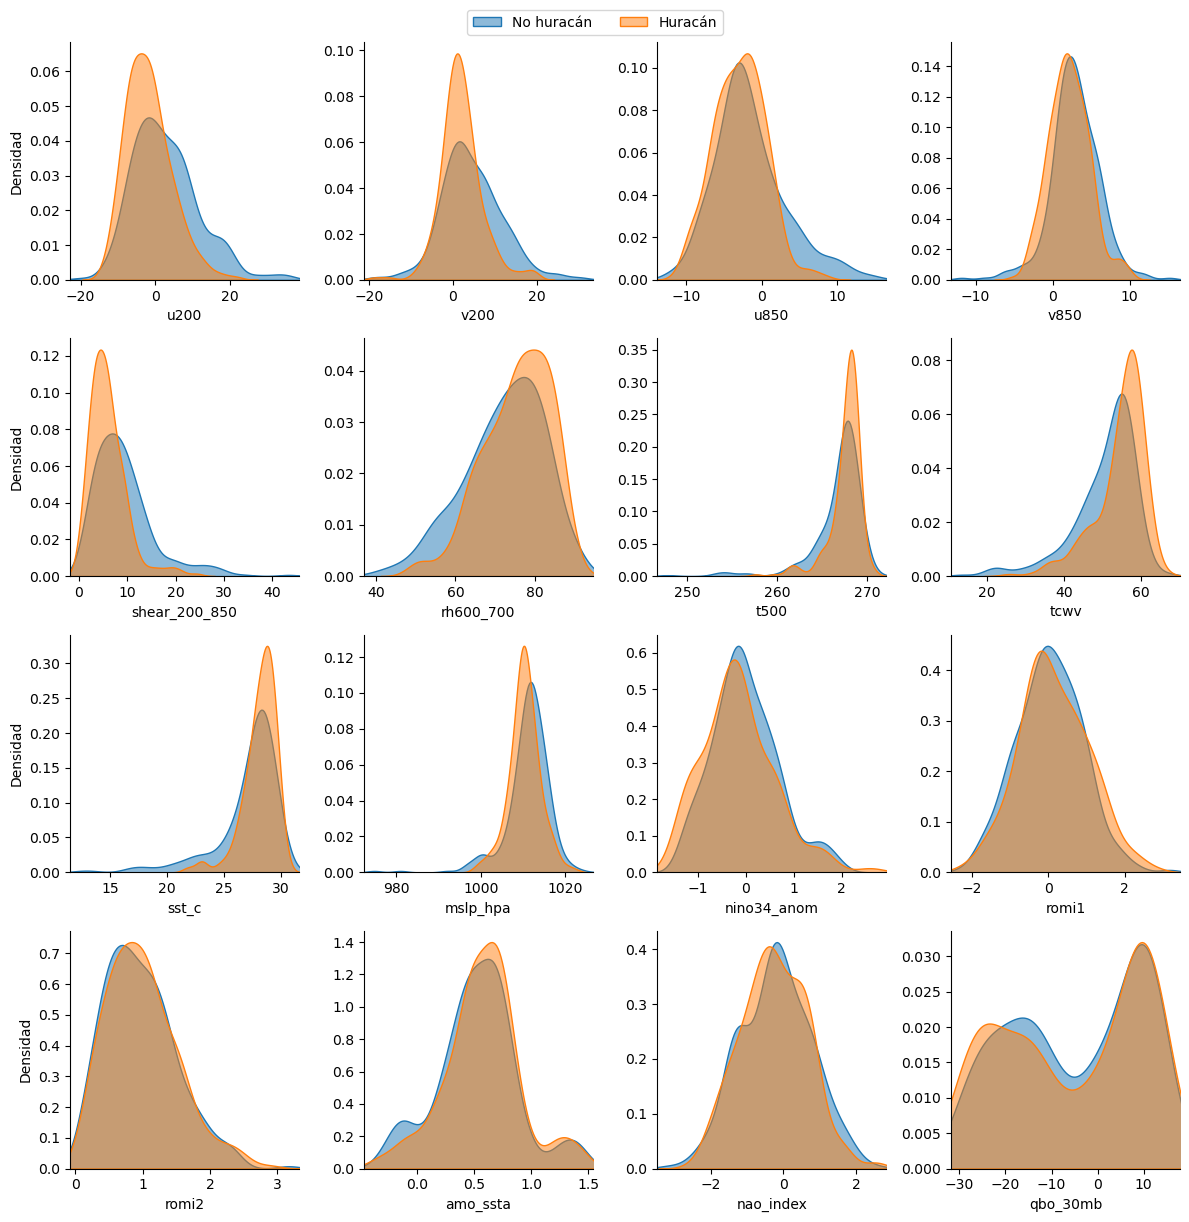

In [ ]:

def grid_densidades_por_clase(datos, target_col="label", col_wrap=4, padding=0.05):
    features = [c for c in datos.columns if c != target_col]
    df_melt = datos[[target_col] + features].melt(
        id_vars=target_col, var_name="feature", value_name="value"
    )

    g = sns.FacetGrid(
        df_melt,
        col="feature",
        hue=target_col,
        col_wrap=col_wrap,
        sharex=False,
        sharey=False
    )
    g.map(sns.kdeplot, "value", fill=True, alpha=0.5)
    g.set_titles("")  # sin título
    g.set_axis_labels("", "Densidad")

    # Ajuste de límites x por variable
    for ax in g.axes.flat:
        feat = df_melt["feature"].unique()[list(g.axes.flat).index(ax)]
        vals = datos[feat].dropna()
        vmin, vmax = vals.min(), vals.max()
        pad = (vmax - vmin) * padding
        ax.set_xlim(vmin - pad, vmax + pad)
        ax.set_xlabel(feat)

    # Leyenda centrada arriba con etiquetas claras
    handles, _ = g.axes.flat[0].get_legend_handles_labels()
    g.fig.legend(
        handles, ["No huracán", "Huracán"],
        loc="upper center", ncol=2, frameon=True, bbox_to_anchor=(0.5, 1.02)
    )
    g.fig.subplots_adjust(top=0.90)

    plt.tight_layout()
    plt.savefig("grid_densidades_por_clase.png", dpi=300, bbox_inches='tight')
    plt.show()
    
# USO:
grid_densidades_por_clase(datos, target_col="label", col_wrap=4, padding=0.05)



# 4) Hiperparámetros

Aquí viven las funciones y clases que soportan todo el flujo:
- Preprocesamiento y pipeline
- Métricas centradas en la clase 1
- Registro de modelos y espacios de hiperparámetros
- Suite de búsquedas (`run_hyperparameter_search_suite`)

In [248]:



# =========================
# Helpers
# =========================
def sanitize_params(model_name: str, params: dict):
    """Corrige tipos (ej: max_depth float->int) para evitar InvalidParameterError."""
    if params is None:
        return None

    clean = dict(params)

    def _to_int_or_none(v):
        if v is None:
            return None
        if isinstance(v, (int, np.integer)):
            return int(v)
        if isinstance(v, (float, np.floating)):
            if np.isnan(v):
                return None
            return int(round(v))
        return v

    def _to_int(v, min_v=1):
        if isinstance(v, (int, np.integer)):
            return max(int(v), min_v)
        if isinstance(v, (float, np.floating)):
            if np.isnan(v):
                return min_v
            return max(int(round(v)), min_v)
        return v

    if model_name in ["BOSQUES", "ÁRBOL"]:
        if "model__max_depth" in clean:
            clean["model__max_depth"] = _to_int_or_none(clean["model__max_depth"])
        if "model__min_samples_split" in clean:
            clean["model__min_samples_split"] = _to_int(clean["model__min_samples_split"], min_v=2)
        if "model__min_samples_leaf" in clean:
            clean["model__min_samples_leaf"] = _to_int(clean["model__min_samples_leaf"], min_v=1)

    return clean


def _densify_if_sparse(X):
    return X.toarray() if hasattr(X, "toarray") else X


def build_preprocessing(datos_train: pd.DataFrame, target_col="label"):
    X = datos_train.drop(columns=[target_col])
    num_cols = list(X.select_dtypes(include=np.number).columns)
    cat_cols = list(X.select_dtypes(exclude=np.number).columns)

    pre_num = StandardScaler()
    pre_cat = OneHotEncoder(handle_unknown="ignore")

    return ColumnTransformer(
        transformers=[
            ("num", pre_num, num_cols),
            ("cat", pre_cat, cat_cols),
        ]
    )


def build_f1_scorer(y):
    classes = pd.Series(y).nunique()
    if classes <= 2:
        return "f1"
    return make_scorer(lambda yt, yp: fbeta_score(yt, yp, beta=1, average="macro", zero_division=0))


def metricas_clase_1(modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)

    precision_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    recall_1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f2_1 = fbeta_score(y_test, y_pred, beta=2, pos_label=1, zero_division=0)

    pr_auc = np.nan
    if hasattr(modelo, "predict_proba"):
        y_score = modelo.predict_proba(X_test)[:, 1]
        pr_auc = average_precision_score(y_test, y_score)
    elif hasattr(modelo, "decision_function"):
        y_score = modelo.decision_function(X_test)
        pr_auc = average_precision_score(y_test, y_score)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn = fp = fn = tp = 0
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()

    return {
        "precision_1": float(precision_1),
        "recall_1": float(recall_1),
        "f2_1": float(f2_1),
        "pr_auc": float(pr_auc) if not np.isnan(pr_auc) else np.nan,
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
    }


def elegir_mejor_estrategia_por_clase1(results, recall_objetivo=0.90):
    candidatos = []
    for strat, info in results.items():
        if strat.startswith("_"):
            continue
        m = info.get("metrics_1", None)
        if m is None:
            continue
        candidatos.append((strat, m))

    if not candidatos:
        return None

    cumplen = [(s, m) for s, m in candidatos if m["recall_1"] >= recall_objetivo]
    pool = cumplen if len(cumplen) > 0 else candidatos

    def key(item):
        _, m = item
        pr = m["pr_auc"]
        pr = -1.0 if np.isnan(pr) else pr
        return (m["recall_1"], pr, m["f2_1"], m["precision_1"])

    best_strat, best_m = sorted(pool, key=key, reverse=True)[0]
    return best_strat, best_m


def build_pipeline(preprocessing, estimator, need_dense: bool):
    steps = [("preprocessor", preprocessing)]
    if need_dense:
        steps.append(("densify", FunctionTransformer(_densify_if_sparse, accept_sparse=True)))
    steps.append(("model", estimator))
    return Pipeline(steps=steps)


def compute_min_resources_for_halving(y_train, k=5, floor=120):
    p_min = pd.Series(y_train).value_counts(normalize=True).min()
    min_res = int(np.ceil(k / max(p_min, 1e-6)))
    return max(min_res, floor)


# =========================
# Coarse-to-Fine Search (arreglado lo_i/hi_i)
# =========================
class CoarseToFineSearchCV:
    def __init__(self,
                 estimator,
                 param_distributions,
                 random_iters=20,
                 top_n_percentile=50,
                 continuous_hyperparams=None,
                 worse_score=-1e9,
                 n_iter=6,
                 scoring=None,
                 n_jobs=None,
                 refit=True,
                 cv=None,
                 random_state=0,
                 verbose=0):

        self.estimator = estimator
        self.param_distributions = param_distributions
        self.random_iters = random_iters
        self.top_n_percentile = top_n_percentile
        self.continuous_hyperparams = continuous_hyperparams or []
        self.worse_score = worse_score
        self.n_iter = n_iter
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.refit = refit
        self.cv = cv
        self.random_state = random_state
        self.verbose = verbose

        self.best_params_ = {}
        self.best_score_ = None

    def fit(self, X, y):
        from scipy.stats import truncnorm

        new_param_distributions = self.param_distributions.copy()
        best_params_dict = {'score': self.worse_score, 'params': []}

        for epoch in range(self.n_iter):
            if self.verbose >= 2:
                print("\n[CoarseToFine] Hyperparameter space:")
                print(new_param_distributions)

            param_list = list(ParameterSampler(
                new_param_distributions,
                n_iter=self.random_iters,
                random_state=self.random_state + epoch
            ))

            rs_results = []
            for i in range(min(self.random_iters, len(param_list))):
                strategy_params = param_list[i]
                estimator = clone(self.estimator).set_params(**strategy_params)

                score = np.mean(cross_val_score(
                    estimator, X, y,
                    cv=self.cv, scoring=self.scoring,
                    n_jobs=self.n_jobs
                ))

                row = dict(strategy_params)
                row["score"] = score
                rs_results.append(row)

                if score >= best_params_dict['score']:
                    best_params_dict['score'] = score
                    best_params_dict['params'] = strategy_params

            df_rs = pd.DataFrame(rs_results).sort_values("score", ascending=False)
            df_rs = df_rs.head(max(5, self.n_iter - epoch))

            if self.verbose >= 1:
                print(f"\n[CoarseToFine] Top candidatos (epoch={epoch+1}):")
                print(df_rs.head(5).to_string(index=False))
                print("[CoarseToFine] Mejor actual:", df_rs.head(1).to_dict(orient="records")[0])
                print("=" * 90)

            percentile_threshold = df_rs["score"].quantile(self.top_n_percentile / 100)
            promising = df_rs[df_rs["score"] >= percentile_threshold].copy()

            numeric_cols = promising.select_dtypes(include=[np.number]).columns
            df_min = promising[numeric_cols].min(axis=0)
            df_max = promising[numeric_cols].max(axis=0)

            for key in list(new_param_distributions.keys()):
                if key not in promising.columns:
                    new_param_distributions[key] = self.param_distributions[key]
                    continue

                val = new_param_distributions[key]
                col = promising[key]
                is_numeric = key in numeric_cols

                if is_numeric:
                    lo = df_min[key]
                    hi = df_max[key]

                    lo_i = int(np.floor(lo)) if not np.isnan(lo) else 1
                    hi_i = int(np.ceil(hi)) if not np.isnan(hi) else lo_i
                    lo_i = max(lo_i, 1)
                    hi_i = max(hi_i, lo_i)

                    if "rv_frozen" in str(type(val)):
                        if key in self.continuous_hyperparams:
                            new_param_distributions[key] = truncnorm(
                                a=float(lo),
                                b=float(hi) + 1e-6,
                                loc=float(0.8 * lo + 0.2 * hi),
                                scale=max(float((0.8 * lo + 0.2 * hi) * 2), 1e-6)
                            )
                        else:
                            new_param_distributions[key] = randint(lo_i, hi_i + 1)

                    elif isinstance(val, (list, tuple)) and len(val) > 0 and isinstance(val[0], int):
                        new_param_distributions[key] = list(range(lo_i, hi_i + 1))

                    elif isinstance(val, (list, tuple)) and len(val) > 0 and isinstance(val[0], float):
                        new_param_distributions[key] = list(np.linspace(float(lo), float(hi), num=len(val)))

                    else:
                        new_param_distributions[key] = self.param_distributions[key]

                else:
                    uniq = [u for u in col.dropna().unique()]
                    new_param_distributions[key] = tuple(uniq) if len(uniq) > 0 else self.param_distributions[key]

        self.best_params_ = dict(best_params_dict["params"])
        self.best_score_ = best_params_dict["score"]

        if self.refit:
            self.estimator = self.estimator.set_params(**self.best_params_)
            self.estimator.fit(X, y)

        return self

    def predict(self, X):
        if not self.refit:
            raise RuntimeError("Estimator no fue refit.")
        return self.estimator.predict(X)


# =========================
# Model Registry (BOSQUES)
# =========================
def model_registry(random_state=0):
    reg = {}

    reg["SVM"] = dict(
        estimator=SVC(),
        need_dense=False,
        grid={
            "model__C": [0.1, 1, 10],
            "model__kernel": ["rbf", "linear"],
            "model__gamma": ["scale", "auto"],
            "model__class_weight": [None, "balanced"],
        },
        rand={
            "model__C": loguniform(1e-2, 1e2),
            "model__kernel": ["rbf", "linear"],
            "model__gamma": ["scale", "auto"],
            "model__class_weight": [None, "balanced"],
        },
        c2f={
            "model__C": loguniform(1e-2, 1e2),
            "model__kernel": ["rbf", "linear"],
            "model__class_weight": [None, "balanced"],
        },
        halving={
            "model__C": loguniform(1e-2, 1e2),
            "model__kernel": ["rbf", "linear"],
            "model__class_weight": [None, "balanced"],
        },
        bayes=None
    )

    reg["KNN"] = dict(
        estimator=KNeighborsClassifier(),
        need_dense=False,
        grid={
            "model__n_neighbors": [3, 5, 7, 11, 21],
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2],
        },
        rand={
            "model__n_neighbors": randint(3, 41),
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2],
        },
        c2f={
            "model__n_neighbors": randint(3, 41),
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2],
        },
        halving={
            "model__n_neighbors": randint(3, 61),
            "model__weights": ["uniform", "distance"],
            "model__p": [1, 2],
        },
        bayes=None
    )

    reg["BAYES"] = dict(
        estimator=GaussianNB(),
        need_dense=True,
        grid={"model__var_smoothing": [1e-12, 1e-10, 1e-9, 1e-8, 1e-7]},
        rand={"model__var_smoothing": loguniform(1e-12, 1e-7)},
        c2f={"model__var_smoothing": loguniform(1e-12, 1e-7)},
        halving={"model__var_smoothing": loguniform(1e-12, 1e-7)},
        bayes=None
    )

    reg["ÁRBOL"] = dict(
        estimator=DecisionTreeClassifier(random_state=random_state),
        need_dense=False,
        grid={
            "model__max_depth": [None, 3, 6, 10, 16],
            "model__min_samples_split": [2, 5, 10, 20, 40],
            "model__min_samples_leaf": [1, 2, 5, 10, 20],
            "model__class_weight": [None, "balanced"],
        },
        rand={
            "model__max_depth": [None] + list(range(2, 21)),
            "model__min_samples_split": randint(2, 41),
            "model__min_samples_leaf": randint(1, 21),
            "model__class_weight": [None, "balanced"],
        },
        c2f={
            "model__max_depth": [None] + list(range(2, 21)),
            "model__min_samples_split": randint(2, 41),
            "model__min_samples_leaf": randint(1, 21),
            "model__class_weight": [None, "balanced"],
        },
        halving={
            "model__max_depth": [None] + list(range(2, 26)),
            "model__min_samples_split": randint(2, 61),
            "model__min_samples_leaf": randint(1, 26),
            "model__class_weight": [None, "balanced"],
        },
        bayes=None
    )

    
    reg["BOSQUES"] = dict(
        estimator=RandomForestClassifier(random_state=random_state),
        need_dense=False,
        grid={
            "model__n_estimators": [200, 400],
            "model__max_depth": [None, 10],
            "model__min_samples_leaf": [1, 5],
            "model__max_features": ["sqrt"],
            "model__class_weight": [None, "balanced"],
        },
        rand={
            "model__n_estimators": randint(100, 801),
            "model__max_depth": [None] + list(range(2, 21)),
            "model__min_samples_split": randint(2, 41),
            "model__min_samples_leaf": randint(1, 21),
            "model__max_features": ["sqrt", "log2", None],
            "model__bootstrap": [True, False],
            "model__class_weight": [None, "balanced", "balanced_subsample"],
            "model__criterion": ["gini", "entropy"],
        },
        c2f={
            "model__n_estimators": randint(100, 801),
            "model__max_depth": [None] + list(range(2, 21)),
            "model__min_samples_split": randint(2, 41),
            "model__min_samples_leaf": randint(1, 21),
            "model__max_features": ["sqrt", "log2", None],
            "model__bootstrap": [True, False],
            "model__class_weight": [None, "balanced", "balanced_subsample"],
            "model__criterion": ["gini", "entropy"],
        },
        halving={
            "model__n_estimators": randint(100, 901),
            "model__max_depth": [None] + list(range(2, 26)),
            "model__min_samples_split": randint(2, 61),
            "model__min_samples_leaf": randint(1, 31),
            "model__max_features": ["sqrt", "log2", None],
            "model__bootstrap": [True, False],
            "model__class_weight": [None, "balanced", "balanced_subsample"],
            "model__criterion": ["gini", "entropy"],
        },
        bayes=None
    )

    reg["POTENCIACIÓN"] = dict(
        estimator=GradientBoostingClassifier(random_state=random_state),
        need_dense=False,
        grid={
            "model__n_estimators": [50, 100, 200],
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__max_depth": [2, 3, 4],
            "model__subsample": [0.8, 1.0],
        },
        rand={
            "model__n_estimators": randint(50, 401),
            "model__learning_rate": loguniform(1e-2, 2e-1),
            "model__max_depth": randint(2, 5),
            "model__subsample": uniform(0.7, 0.3),
        },
        c2f={
            "model__n_estimators": randint(50, 401),
            "model__learning_rate": loguniform(1e-2, 2e-1),
            "model__max_depth": randint(2, 5),
            "model__subsample": uniform(0.7, 0.3),
        },
        halving={
            "model__n_estimators": randint(50, 601),
            "model__learning_rate": loguniform(1e-2, 2e-1),
            "model__max_depth": randint(2, 6),
            "model__subsample": uniform(0.7, 0.3),
        },
        bayes=None
    )

    reg["RED"] = dict(
        estimator=MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=random_state),
        need_dense=True,
        grid={
            "model__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
            "model__activation": ["relu", "tanh"],
            "model__alpha": [1e-4, 1e-3, 1e-2],
            "model__learning_rate_init": [1e-3, 1e-2],
        },
        rand={
            "model__hidden_layer_sizes": [(50,), (100,), (150,), (50, 50), (100, 50), (100, 100)],
            "model__activation": ["relu", "tanh"],
            "model__alpha": loguniform(1e-5, 1e-2),
            "model__learning_rate_init": loguniform(1e-4, 5e-2),
        },
        c2f={
            "model__hidden_layer_sizes": [(50,), (100,), (150,), (50, 50), (100, 50), (100, 100)],
            "model__activation": ["relu", "tanh"],
            "model__alpha": loguniform(1e-5, 1e-2),
            "model__learning_rate_init": loguniform(1e-4, 5e-2),
        },
        halving={
            "model__hidden_layer_sizes": [(50,), (100,), (150,), (50, 50), (100, 50), (100, 100)],
            "model__activation": ["relu", "tanh"],
            "model__alpha": loguniform(1e-5, 1e-2),
            "model__learning_rate_init": loguniform(1e-4, 5e-2),
        },
        bayes=None
    )

    reg["GLM"] = dict(
        estimator=LogisticRegression(max_iter=800, solver="liblinear"),
        need_dense=False,
        grid={"model__C": [0.01, 0.1, 1, 10], "model__class_weight": [None, "balanced"]},
        rand={"model__C": loguniform(1e-3, 1e2), "model__class_weight": [None, "balanced"]},
        c2f={"model__C": loguniform(1e-3, 1e2), "model__class_weight": [None, "balanced"]},
        halving={"model__C": loguniform(1e-3, 1e2), "model__class_weight": [None, "balanced"]},
        bayes=None
    )

    reg["GLMNET"] = dict(
        estimator=LogisticRegression(max_iter=1200, solver="saga", penalty="elasticnet"),
        need_dense=False,
        grid={
            "model__C": [0.01, 0.1, 1, 10],
            "model__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9],
            "model__class_weight": [None, "balanced"],
        },
        rand={
            "model__C": loguniform(1e-3, 1e2),
            "model__l1_ratio": uniform(0.05, 0.95),
            "model__class_weight": [None, "balanced"],
        },
        c2f={
            "model__C": loguniform(1e-3, 1e2),
            "model__l1_ratio": uniform(0.05, 0.95),
            "model__class_weight": [None, "balanced"],
        },
        halving={
            "model__C": loguniform(1e-3, 1e2),
            "model__l1_ratio": uniform(0.05, 0.95),
            "model__class_weight": [None, "balanced"],
        },
        bayes=None
    )

    if SKOPT_OK:
        reg["SVM"]["bayes"] = {
            "model__C": Real(1e-2, 1e2, prior="log-uniform"),
            "model__kernel": Categorical(["rbf", "linear"]),
            "model__class_weight": Categorical([None, "balanced"]),
            "model__gamma": Categorical(["scale", "auto"]),
        }
        reg["KNN"]["bayes"] = {
            "model__n_neighbors": Integer(3, 60),
            "model__weights": Categorical(["uniform", "distance"]),
            "model__p": Categorical([1, 2]),
        }
        reg["BAYES"]["bayes"] = {"model__var_smoothing": Real(1e-12, 1e-7, prior="log-uniform")}
        reg["ÁRBOL"]["bayes"] = {
            "model__max_depth": Integer(2, 20),
            "model__min_samples_split": Integer(2, 60),
            "model__min_samples_leaf": Integer(1, 25),
            "model__class_weight": Categorical([None, "balanced"]),
        }
        reg["BOSQUES"]["bayes"] = {
            "model__n_estimators": Integer(100, 900),
            "model__max_depth": Integer(2, 25),
            "model__min_samples_split": Integer(2, 60),
            "model__min_samples_leaf": Integer(1, 30),
            "model__max_features": Categorical(["sqrt", "log2"]),
            "model__bootstrap": Categorical([True, False]),
            "model__class_weight": Categorical([None, "balanced", "balanced_subsample"]),
            "model__criterion": Categorical(["gini", "entropy"]),
        }
        reg["POTENCIACIÓN"]["bayes"] = {
            "model__n_estimators": Integer(50, 600),
            "model__learning_rate": Real(1e-2, 2e-1, prior="log-uniform"),
            "model__max_depth": Integer(2, 5),
            "model__subsample": Real(0.7, 1.0),
        }
        reg["RED"]["bayes"] = {
            "model__activation": Categorical(["relu", "tanh"]),
            "model__alpha": Real(1e-5, 1e-2, prior="log-uniform"),
            "model__learning_rate_init": Real(1e-4, 5e-2, prior="log-uniform"),
        }
        reg["GLM"]["bayes"] = {"model__C": Real(1e-3, 1e2, prior="log-uniform"),
                              "model__class_weight": Categorical([None, "balanced"])}
        reg["GLMNET"]["bayes"] = {"model__C": Real(1e-3, 1e2, prior="log-uniform"),
                                  "model__l1_ratio": Real(0.05, 1.0),
                                  "model__class_weight": Categorical([None, "balanced"])}

    return reg


# =========================
# Runner: 5 búsquedas por modelo + métricas clase 1 en todas
# =========================
def run_5_searches_for_model(
    model_name,
    pipe,
    spaces,
    X_train, y_train,
    X_test, y_test,
    scorer,
    cv,
    n_jobs=-1,
    random_iters=40,      
    bayes_iters=20,       
    c2f_epochs=4,         
    c2f_random_iters=12,  
    verbose=1,
    recall_objetivo=0.90
):
    results = {}

    # BASELINE
    try:
        base = clone(pipe)
        base.fit(X_train, y_train)
        m1 = metricas_clase_1(base, X_test, y_test)
        results["BASELINE"] = dict(best_params=None, cv_score=None, test_score=None, metrics_1=m1)
    except Exception as e:
        print(f"[BASELINE ERROR] {model_name}: {type(e).__name__}: {e}")
        results["BASELINE"] = dict(best_params=None, cv_score=None, test_score=None, metrics_1=None)

    # GRID
    try:
        gs = GridSearchCV(
            estimator=clone(pipe),
            param_grid=spaces["grid"],
            scoring=scorer,
            cv=cv,
            n_jobs=n_jobs,
            refit=True,
            verbose=verbose
        )
        gs.fit(X_train, y_train)
        m1 = metricas_clase_1(gs, X_test, y_test)
        results["GRID"] = dict(
            best_params=sanitize_params(model_name, gs.best_params_),
            cv_score=gs.best_score_,
            test_score=gs.score(X_test, y_test),
            metrics_1=m1
        )
    except (InvalidParameterError, ValueError, TypeError) as e:
        print(f"[GRID SKIP] {model_name} -> {type(e).__name__}: {e}")
        results["GRID"] = dict(best_params=None, cv_score=None, test_score=None, metrics_1=None)

    # RANDOM
    try:
        rs = RandomizedSearchCV(
            estimator=clone(pipe),
            param_distributions=spaces["rand"],
            n_iter=random_iters,
            random_state=0,
            scoring=scorer,
            cv=cv,
            n_jobs=n_jobs,
            refit=True,
            verbose=verbose
        )
        rs.fit(X_train, y_train)
        m1 = metricas_clase_1(rs, X_test, y_test)
        results["RANDOM"] = dict(
            best_params=sanitize_params(model_name, rs.best_params_),
            cv_score=rs.best_score_,
            test_score=rs.score(X_test, y_test),
            metrics_1=m1
        )
    except (InvalidParameterError, ValueError, TypeError) as e:
        print(f"[RANDOM SKIP] {model_name} -> {type(e).__name__}: {e}")
        results["RANDOM"] = dict(best_params=None, cv_score=None, test_score=None, metrics_1=None)

    # COARSE2FINE
    try:
        c2f = CoarseToFineSearchCV(
            estimator=clone(pipe),
            param_distributions=spaces["c2f"],
            random_iters=c2f_random_iters,
            top_n_percentile=50,
            random_state=0,
            scoring=scorer,
            cv=cv,
            n_jobs=n_jobs,
            refit=True,
            n_iter=c2f_epochs,
            verbose=1 if verbose else 0
        )
        c2f.fit(X_train, y_train)
        m1 = metricas_clase_1(c2f, X_test, y_test)
        results["COARSE2FINE"] = dict(
            best_params=sanitize_params(model_name, c2f.best_params_),
            cv_score=c2f.best_score_,
            test_score=None,
            metrics_1=m1
        )
    except (InvalidParameterError, ValueError, TypeError) as e:
        print(f"[COARSE2FINE SKIP] {model_name} -> {type(e).__name__}: {e}")
        results["COARSE2FINE"] = dict(best_params=None, cv_score=None, test_score=None, metrics_1=None)

    # HALVING
    try:
        min_resources = compute_min_resources_for_halving(
            y_train,
            k=cv.n_splits if hasattr(cv, "n_splits") else 5,
            floor=120
        )
        halving = HalvingRandomSearchCV(
            estimator=clone(pipe),
            param_distributions=spaces["halving"],
            factor=3,
            aggressive_elimination=False,
            resource="n_samples",
            min_resources=min_resources,
            scoring=scorer,
            cv=cv,
            n_jobs=n_jobs,
            refit=True,
            verbose=verbose
        )
        halving.fit(X_train, y_train)
        m1 = metricas_clase_1(halving, X_test, y_test)
        results["HALVING"] = dict(
            best_params=sanitize_params(model_name, halving.best_params_),
            cv_score=halving.best_score_,
            test_score=halving.score(X_test, y_test),
            metrics_1=m1
        )
    except (InvalidParameterError, ValueError, TypeError) as e:
        print(f"[HALVING SKIP] {model_name} -> {type(e).__name__}: {e}")
        results["HALVING"] = dict(best_params=None, cv_score=None, test_score=None, metrics_1=None)

    # BAYES
    if SKOPT_OK and spaces.get("bayes") is not None:
        try:
            bayes = BayesSearchCV(
                estimator=clone(pipe),
                search_spaces=spaces["bayes"],
                n_iter=bayes_iters,
                random_state=0,
                scoring=scorer,
                cv=cv,
                n_jobs=n_jobs,
                refit=True,
                verbose=verbose
            )
            bayes.fit(X_train, y_train)
            m1 = metricas_clase_1(bayes, X_test, y_test)
            results["BAYES"] = dict(
                best_params=sanitize_params(model_name, bayes.best_params_),
                cv_score=bayes.best_score_,
                test_score=bayes.score(X_test, y_test),
                metrics_1=m1
            )
        except Exception as e:
            print(f"[BAYES SKIP] {model_name} -> {type(e).__name__}: {e}")
            results["BAYES"] = dict(best_params=None, cv_score=None, test_score=None, metrics_1=None)
    else:
        results["BAYES"] = dict(best_params=None, cv_score=None, test_score=None, metrics_1=None)

   
    pick = elegir_mejor_estrategia_por_clase1(results, recall_objetivo=recall_objetivo)
    if pick is None:
        results["_BEST_"] = dict(strategy=None, metrics_1=None, best_params=None)
    else:
        best_strategy, best_m = pick
        bp = results[best_strategy]["best_params"]
        results[best_strategy]["best_params"] = sanitize_params(model_name, bp)
        results["_BEST_"] = dict(
            strategy=best_strategy,
            metrics_1=best_m,
            best_params=results[best_strategy]["best_params"]
        )

    return results


# =========================
# Suite principal
# =========================
def run_hyperparameter_search_suite(
    datos: pd.DataFrame,
    target_col="label",
    modelos="preguntar",
    test_size=0.10,
    random_state=0,
    n_jobs=-1,
    verbose=1,
    cv_splits="preguntar",
    recall_objetivo="preguntar",
):
    X = datos.drop(columns=[target_col])
    y = datos[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    datos_train = X_train.copy()
    datos_train[target_col] = y_train.values
    preprocessing = build_preprocessing(datos_train, target_col=target_col)

    scorer = build_f1_scorer(y_train)

    if cv_splits == "preguntar":
        while True:
            try:
                k = int(input("¿Cuántos folds (k) para validación cruzada? (recomendado 5): ").strip())
                if k < 2:
                    print("k debe ser >= 2.")
                    continue
                minor = pd.Series(y_train).value_counts().min()
                if k > minor:
                    print(f"Advertencia: k={k} > clase minoritaria ({minor}). Baja k.")
                    continue
                cv_splits = k
                break
            except ValueError:
                print("Ingresa un entero (ej: 5).")
    else:
        if not isinstance(cv_splits, int) or cv_splits < 2:
            raise ValueError("cv_splits debe ser entero >=2 o 'preguntar'.")

    if recall_objetivo == "preguntar":
        while True:
            try:
                r = float(input("Recall mínimo deseado para clase 1 (ej: 0.90): ").strip())
                if r <= 0 or r > 1:
                    print("Debe estar en (0,1].")
                    continue
                recall_objetivo = r
                break
            except ValueError:
                print("Ingresa un número válido (ej: 0.90).")
    else:
        if not isinstance(recall_objetivo, (int, float)) or recall_objetivo <= 0 or recall_objetivo > 1:
            raise ValueError("recall_objetivo debe estar en (0,1] o 'preguntar'.")

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    reg = model_registry(random_state=random_state)
    disponibles = list(reg.keys())

    if modelos == "preguntar":
        print("Modelos disponibles:", disponibles)
        user_in = input("Escribe 'todos' o lista separada por comas (ej: SVM,KNN,GLM): ").strip()
        modelos_sel = disponibles if user_in.lower() == "todos" else [x.strip() for x in user_in.split(",") if x.strip()]
    elif modelos == "todos":
        modelos_sel = disponibles
    elif isinstance(modelos, (list, tuple, set)):
        modelos_sel = [m for m in modelos if m in disponibles]
    else:
        modelos_sel = disponibles

    if not modelos_sel:
        raise ValueError("No hay modelos seleccionados válidos.")

    print("\n==============================")
    print("SCORING (para CV):", scorer)
    print("CV folds (k):", cv_splits)
    print("Recall objetivo clase 1:", recall_objetivo)
    print("SKOPT disponible:", SKOPT_OK)
    print("MODELOS A CORRER:", modelos_sel)
    print("==============================\n")

    all_results = {}
    resumen_rows = []

    for name in modelos_sel:
        print("\n\n#############################################")
        print(f"### MODELO: {name}")
        print("#############################################")

        estimator = reg[name]["estimator"]
        need_dense = reg[name]["need_dense"]

        pipe = build_pipeline(preprocessing, estimator, need_dense)

        spaces = {
            "grid": reg[name]["grid"],
            "rand": reg[name]["rand"],
            "c2f": reg[name]["c2f"],
            "halving": reg[name]["halving"],
            "bayes": reg[name]["bayes"],
        }

        out = run_5_searches_for_model(
            model_name=name,
            pipe=pipe,
            spaces=spaces,
            X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test,
            scorer=scorer,
            cv=cv,
            n_jobs=n_jobs,
            verbose=verbose,
            recall_objetivo=recall_objetivo
        )

        all_results[name] = out

        print("\n--- RESUMEN POR ESTRATEGIA (CLASE 1) ---")
        for strat in ["BASELINE", "GRID", "RANDOM", "COARSE2FINE", "HALVING", "BAYES"]:
            m = out.get(strat, {}).get("metrics_1", None)
            if m is None:
                print(f"{strat:12s} | (sin métricas / skip)")
                continue
            pr = m["pr_auc"]
            pr_txt = "NA" if np.isnan(pr) else f"{pr:.4f}"
            print(f"{strat:12s} | recall_1={m['recall_1']:.4f} | precision_1={m['precision_1']:.4f} | f2_1={m['f2_1']:.4f} | pr_auc={pr_txt} | fp={m['fp']} fn={m['fn']}")

        best = out["_BEST_"]
        bm = best["metrics_1"] if best["metrics_1"] else {}
        print("\n>>> MEJOR (orientado a clase 1):", best["strategy"])
        if bm:
            pr = bm["pr_auc"]
            pr_txt = "NA" if np.isnan(pr) else f"{pr:.4f}"
            print(f">>> recall_1={bm['recall_1']:.4f} | precision_1={bm['precision_1']:.4f} | f2_1={bm['f2_1']:.4f} | pr_auc={pr_txt} | fp={bm['fp']} fn={bm['fn']}")
        print(">>> PARAMS:", best["best_params"])

        resumen_rows.append({
            "modelo": name,
            "mejor_estrategia": best["strategy"],
            "precision_1": bm.get("precision_1", np.nan),
            "recall_1": bm.get("recall_1", np.nan),
            "f2_1": bm.get("f2_1", np.nan),
            "pr_auc": bm.get("pr_auc", np.nan),
            "fp": bm.get("fp", np.nan),
            "fn": bm.get("fn", np.nan),
            "best_params": best["best_params"],
        })

    resumen = pd.DataFrame(resumen_rows).sort_values(
        ["recall_1", "pr_auc", "f2_1", "precision_1"],
        ascending=[False, False, False, False]
    ).reset_index(drop=True)

    print("\n\n====================================================")
    print("RESUMEN GLOBAL (selección orientada a clase 1)")
    print("====================================================")
    print(resumen.to_string(index=False))

    return all_results, resumen


# =========================
# USO
# =========================
# all_results, resumen = run_hyperparameter_search_suite(
#     datos,
#     modelos="todos",
#     cv_splits=5,
#     recall_objetivo=0.90,
#     verbose=1
# )


# 5) CV con hiperparametros encontrados anteriormente.

In [ ]:



def competir_modelos_cv_fijo(
    datos: pd.DataFrame,
    resumen: pd.DataFrame,
    target_col="label",
    cv_splits=5,
    random_state=0
):
    """
    Evalúa cada modelo con hiperparámetros fijos (best_params del resumen)
    usando CV estratificada. Reporta promedio y desviación estándar.
    """
    X = datos.drop(columns=[target_col])
    y = datos[target_col]

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    reg = model_registry(random_state=random_state)

    rows = []

    for _, row in resumen.iterrows():
        name = row["modelo"]
        best_params = row.get("best_params", None)

        estimator = reg[name]["estimator"]
        need_dense = reg[name]["need_dense"]

        # métricas por fold
        fold_metrics = []

        for fold_id, (tr_idx, te_idx) in enumerate(cv.split(X, y), start=1):
            X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
            y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

            datos_tr = X_tr.copy()
            datos_tr[target_col] = y_tr.values
            preprocessing = build_preprocessing(datos_tr, target_col=target_col)

            pipe = build_pipeline(preprocessing, estimator, need_dense)

            # aplicar best_params
            used_params = None
            if isinstance(best_params, dict) and len(best_params) > 0:
                used_params = sanitize_params(name, best_params)
                pipe = pipe.set_params(**used_params)

            pipe.fit(X_tr, y_tr)
            m1 = metricas_clase_1(pipe, X_te, y_te)
            fold_metrics.append(m1)

        # agregados
        def mean_std(key):
            vals = [m[key] for m in fold_metrics]
            return float(np.mean(vals)), float(np.std(vals))

        rec_m, rec_s = mean_std("recall_1")
        prec_m, prec_s = mean_std("precision_1")
        f2_m, f2_s = mean_std("f2_1")
        pr_m, pr_s = mean_std("pr_auc")
        fn_m, fn_s = mean_std("fn")
        fp_m, fp_s = mean_std("fp")

        rows.append({
            "modelo": name,
            "recall_mean": rec_m, "recall_std": rec_s,
            "precision_mean": prec_m, "precision_std": prec_s,
            "f2_mean": f2_m, "f2_std": f2_s,
            "pr_auc_mean": pr_m, "pr_auc_std": pr_s,
            "fn_mean": fn_m, "fn_std": fn_s,
            "fp_mean": fp_m, "fp_std": fp_s,
            "best_params": used_params
        })

    df_cv = pd.DataFrame(rows)

    # Ranking (min FN sin muchos FP)
    df_rank = df_cv.sort_values(
        by=["recall_mean", "fn_mean", "pr_auc_mean", "f2_mean", "precision_mean", "fp_mean"],
        ascending=[False, True, False, False, False, True]
    ).reset_index(drop=True)

    print("\n==============================")
    print("COMPETENCIA CV (hiperparámetros fijos)")
    print("==============================")
    print(df_rank.to_string(index=False))

    print("\n>>> MEJOR MODELO (CV fijo):", df_rank.iloc[0]["modelo"])
    return df_rank


# 6) Entrenamiento final con TODO el dataset (solo después de decidir el modelo)



In [ ]:



def _coerce_params_to_dict(best_params):
    """
    Convierte best_params a dict si viene como string tipo "{'a':1}".
    Si es NaN/None -> None.
    """
    if best_params is None:
        return None
    if isinstance(best_params, float) and np.isnan(best_params):
        return None
    if isinstance(best_params, dict):
        return best_params
    if isinstance(best_params, str):
        s = best_params.strip()
        if s == "" or s.lower() == "none" or s.lower() == "nan":
            return None
        try:
            obj = ast.literal_eval(s)
            return obj if isinstance(obj, dict) else None
        except Exception:
            return None
    return None


def entrenar_modelo_final_con_todo(
    datos: pd.DataFrame,
    resumen: pd.DataFrame,
    target_col="label",
    random_state=0,
    modelo_elegido=None,
    verbose=True
):
    """
    Entrena un modelo final con TODO el dataset.
    - Si modelo_elegido is None: usa resumen.iloc[0]['modelo'].
    - Si modelo_elegido string: usa esa fila del resumen.
    """

    # 1) Validación target
    if target_col not in datos.columns:
        raise KeyError(
            f"No existe target_col='{target_col}' en datos.\n"
            f"Columnas disponibles: {list(datos.columns)[:30]} ..."
        )

    # 2) Registry
    reg = model_registry(random_state=random_state)

    # 3) Decidir modelo
    if modelo_elegido is None:
        if "modelo" not in resumen.columns:
            raise KeyError("El resumen no tiene columna 'modelo'.")
        modelo_elegido = str(resumen.iloc[0]["modelo"])

    if modelo_elegido not in reg:
        raise ValueError(
            f"modelo_elegido='{modelo_elegido}' no existe en model_registry(). "
            f"Disponibles: {list(reg.keys())}"
        )

    # 4) Obtener best_params del resumen
    fila = resumen[resumen["modelo"] == modelo_elegido]
    if fila.empty:
        raise ValueError(
            f"No encontré '{modelo_elegido}' dentro del resumen.\n"
            f"Modelos en resumen: {sorted(resumen['modelo'].unique().tolist())}"
        )

    best_params_raw = fila.iloc[0].get("best_params", None)
    best_params = _coerce_params_to_dict(best_params_raw)

    # 5) Preprocessing con TODO el dataset
    preprocessing_full = build_preprocessing(datos, target_col=target_col)

    X_all = datos.drop(columns=[target_col])
    y_all = datos[target_col]

    estimator = reg[modelo_elegido]["estimator"]
    need_dense = reg[modelo_elegido]["need_dense"]
    pipe_final = build_pipeline(preprocessing_full, estimator, need_dense)

    params_usados = None
    if isinstance(best_params, dict) and len(best_params) > 0:
        params_usados = sanitize_params(modelo_elegido, best_params)
        pipe_final = pipe_final.set_params(**params_usados)

    if verbose:
        print("\n=== ENTRENAMIENTO FINAL (TODO EL DATASET) ===")
        print("Modelo:", modelo_elegido)
        print("Aplica params:", "SI" if params_usados else "NO (baseline)")
        print("Params usados:", params_usados)

    # 6) Fit final
    pipe_final.fit(X_all, y_all)

    return modelo_elegido, pipe_final, params_usados



## Ejecución Hiperparámetros y CV con hiperparámetros 

In [ ]:
# =========================
# USO (opción C: CV con hiperparámetros fijos)
# =========================

# 1) Buscar hiperparámetros por modelo
all_results, resumen = run_hyperparameter_search_suite(
    datos,
    modelos="todos",
    cv_splits=5,
    recall_objetivo=0.90,
    verbose=1
)

# 2) Competir modelos con hiperparámetros fijos usando CV
df_rank_cv = competir_modelos_cv_fijo(
    datos,
    resumen,
    target_col="label",
    cv_splits=5,
    random_state=0
)





SCORING (para CV): f1
CV folds (k): 5
Recall objetivo clase 1: 0.9
SKOPT disponible: True
MODELOS A CORRER: ['SVM', 'KNN', 'BAYES', 'ÁRBOL', 'BOSQUES', 'POTENCIACIÓN', 'RED', 'GLM', 'GLMNET']



#############################################
### MODELO: SVM
#############################################
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits

[CoarseToFine] Top candidatos (epoch=1):
 model__C model__class_weight model__kernel    score
 0.495016            balanced           rbf 0.657700
 2.576639            balanced        linear 0.647948
 1.871450            balanced        linear 0.647948
 0.701322            balanced        linear 0.644731
 0.012047            balanced        linear 0.644275
[CoarseToFine] Mejor actual: {'model__C': 0.49501595537331966, 'model__class_weight': 'balanced', 'model__kernel': 'rbf', 'score': 0.6577002920555071}

[CoarseToFine] Top candidatos (epoch=2):
 model__C model__cl

c:\Users\josep\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [8.607557142744174e-12] before, using random point [4.80247153680379e-08]
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [6.751158441033136e-11] before, using random point [5.7262565870769306e-12]
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.1860366821073956e-08] before, using random point [1.6881573454206964e-09]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\josep\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [3.142386801853084e-09] before, using random point [5.604208617893792e-11]
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [7.412345773870325e-08] before, using random point [1.2353993666517526e-09]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits

--- RESUMEN POR ESTRATEGIA (CLASE 1) ---
BASELINE     | recall_1=0.9600 | precision_1=0.5333 | f2_1=0.8276 | pr_auc=0.6577 | fp=21 fn=1
GRID         | recall_1=0.9600 | precision_1=0.5333 | f2_1=0.8276 | pr_auc=0.6577 | fp=21 fn=1
RANDOM       | recall_1=0.9600 | precision_1=0.5333 | f2_1=0.8276 | pr_auc=0.6577 | fp=21 fn=1
COARSE2FINE  | recall_1=0.9600 | precision_1=0.5333 | f2_1=0.8276 | pr_auc=NA | fp=21 fn=1
HALVING      | recall_1=0.9600 | precision_1=0.5333 | f2_1=0.8276 | pr_auc=0.6577 | fp=21 fn=1
BAYES        | recall_1=0.9600 | precision_1=0.5333 | f2_1=0.8276 | pr_auc=0.6577 | fp=21 fn=1

>>> MEJOR (orientado a clase 1): BASE

c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 48 candidates, totalling 240 fits


c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Fitting 5 folds for each of 40 candidates, totalling 200 fits

[CoarseToFine] Top candidatos (epoch=1):
model__activation  model__alpha model__hidden_layer_sizes  model__learning_rate_init    score
             relu      0.000601                     (50,)                   0.004235 0.634860
             tanh      0.001887                    (150,)                   0.001316 0.632399
             tanh      0.000036                    (150,)                   0.001703 0.629023
             relu      0.000271                     (50,)                   0.001148 0.607836
             relu      0.001452                    (100,)                   0.000244 0.606599
[CoarseToFine] Mejor actual: {'model__activation': 'relu', 'model__alpha': 0.0006005288202683082, 'model__hidden_layer_sizes': (50,), 'model__learning_rate_init': 0.004234871839273794, 'score': 0.6348595390011538}

[CoarseToFine] Top candidatos (epoch=2):
model__activation  model__alpha model__hidden_layer_sizes  model__learning_r

c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 120
max_resources_: 506
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 120
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 360
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates

c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(



--- RESUMEN POR ESTRATEGIA (CLASE 1) ---
BASELINE     | recall_1=0.6800 | precision_1=0.5312 | f2_1=0.6439 | pr_auc=0.5961 | fp=15 fn=8
GRID         | recall_1=0.7200 | precision_1=0.5806 | f2_1=0.6870 | pr_auc=0.6186 | fp=13 fn=7
RANDOM       | recall_1=0.7200 | precision_1=0.6207 | f2_1=0.6977 | pr_auc=0.6773 | fp=11 fn=7
COARSE2FINE  | recall_1=0.6000 | precision_1=0.5769 | f2_1=0.5952 | pr_auc=NA | fp=11 fn=10
HALVING      | recall_1=0.6000 | precision_1=0.5769 | f2_1=0.5952 | pr_auc=0.6474 | fp=11 fn=10
BAYES        | recall_1=0.7600 | precision_1=0.6552 | f2_1=0.7364 | pr_auc=0.7083 | fp=10 fn=6

>>> MEJOR (orientado a clase 1): BAYES
>>> recall_1=0.7600 | precision_1=0.6552 | f2_1=0.7364 | pr_auc=0.7083 | fp=10 fn=6
>>> PARAMS: {'model__activation': 'tanh', 'model__alpha': 0.0005127887170992832, 'model__learning_rate_init': 0.0012322585437428654}


#############################################
### MODELO: GLM
#############################################
Fitting 5 folds for eac

c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multi


COMPETENCIA CV (hiperparámetros fijos)
      modelo  recall_mean  recall_std  precision_mean  precision_std  f2_mean   f2_std  pr_auc_mean  pr_auc_std  fn_mean   fn_std  fp_mean   fp_std                                                                                                                                                                                                                                           best_params
       BAYES        0.816    0.034409        0.532904       0.016478 0.737358 0.025547     0.642753    0.032983      9.2 1.720465     35.8 2.315167                                                                                                                                                                                                                                                  None
      GLMNET        0.720    0.056569        0.621554       0.044649 0.697371 0.050156     0.711211    0.069734     14.0 2.828427     22.0 3.162278                         

## Escoger solo mejores modelos minimizando FN sin maximizar FP

In [252]:
# =========================
# Selección con FP no extremo (P75) y FN mínimo
# =========================
fp_p75 = df_rank_cv["fp_mean"].quantile(0.75)

df_candidatos = df_rank_cv[df_rank_cv["fp_mean"] <= fp_p75].copy()

# Si por alguna razón queda vacío, usar todos
pool = df_candidatos if len(df_candidatos) > 0 else df_rank_cv

df_seleccion = pool.sort_values(
    by=["fn_mean", "fp_mean", "recall_mean", "f2_mean", "precision_mean"],
    ascending=[True, True, False, False, False]
).reset_index(drop=True)

modelo_paper = df_seleccion.iloc[0]["modelo"]

print("FP P75:", fp_p75)
print("\n=== CANDIDATOS (FP <= P75) ===")
print(pool.to_string(index=False))
print("\n=== SELECCIÓN FINAL ===")
print(df_seleccion.to_string(index=False))
print("\n>>> MODELO ELEGIDO:", modelo_paper)


FP P75: 22.0

=== CANDIDATOS (FP <= P75) ===
      modelo  recall_mean  recall_std  precision_mean  precision_std  f2_mean   f2_std  pr_auc_mean  pr_auc_std  fn_mean   fn_std  fp_mean   fp_std                                                                                                                                                                                                                                           best_params
      GLMNET        0.720    0.056569        0.621554       0.044649 0.697371 0.050156     0.711211    0.069734     14.0 2.828427     22.0 3.162278                                                                                                                                             {'model__C': 9.091283280651457, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.5059783137563044}
         GLM        0.720    0.056569        0.621554       0.044649 0.697371 0.050156     0.710965    0.069473     14.0 2.828427     22.0 3.162278                    

## Mejor modelo, se entrena con todo el dataset

In [253]:
# 3) Elegir mejor modelo (el primero del ranking)
modelo_paper = df_seleccion.iloc[0]["modelo"]
print("Modelo elegido para el paper:", modelo_paper)

# 4) Entrenar modelo final con todo el dataset
ganador, modelo_final, params_final = entrenar_modelo_final_con_todo(
    datos,
    resumen,
    modelo_elegido=modelo_paper
)

Modelo elegido para el paper: GLMNET

=== ENTRENAMIENTO FINAL (TODO EL DATASET) ===
Modelo: GLMNET
Aplica params: SI
Params usados: {'model__C': 9.091283280651457, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.5059783137563044}


## Se guarda el modelo para nuevos individuos

In [ ]:


joblib.dump(modelo_final, "modelo_final.joblib")


modelo_cargado = joblib.load("modelo_final.joblib")


### Predecir un nuevo indiviuo. El dataset debe tener las mismas columnas que el original (excepto target_col).
#pred = modelo_cargado.predict(X_nuevo)

# 7) Visualizaciones y matrices

In [ ]:
# =========================
# 1) Matriz de confusión promedio (CV)
# =========================




def confusion_matrix_cv_promedio(
    datos, df_seleccion, target_col="label", cv_splits=5, random_state=0
):
    X = datos.drop(columns=[target_col])
    y = datos[target_col]
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    reg = model_registry(random_state=random_state)

    rows = []
    for _, row in df_seleccion.iterrows():
        name = row["modelo"]
        best_params = row.get("best_params", None)

        estimator = reg[name]["estimator"]
        need_dense = reg[name]["need_dense"]

        cms = []
        for tr_idx, te_idx in cv.split(X, y):
            X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
            y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

            datos_tr = X_tr.copy()
            datos_tr[target_col] = y_tr.values
            preprocessing = build_preprocessing(datos_tr, target_col=target_col)

            pipe = build_pipeline(preprocessing, estimator, need_dense)
            if isinstance(best_params, dict) and len(best_params) > 0:
                pipe = pipe.set_params(**sanitize_params(name, best_params))

            pipe.fit(X_tr, y_tr)
            y_pred = pipe.predict(X_te)
            cm = confusion_matrix(y_te, y_pred, labels=[0,1])
            cms.append(cm)

        cms = np.array(cms)
        cm_mean = cms.mean(axis=0)
        cm_std = cms.std(axis=0)

        rows.append({
            "modelo": name,
            "TN_mean": cm_mean[0,0], "FP_mean": cm_mean[0,1],
            "FN_mean": cm_mean[1,0], "TP_mean": cm_mean[1,1],
            "TN_std": cm_std[0,0], "FP_std": cm_std[0,1],
            "FN_std": cm_std[1,0], "TP_std": cm_std[1,1],
        })

    df_cm = pd.DataFrame(rows)
    print("\n=== MATRIZ DE CONFUSIÓN PROMEDIO (CV) ===")
    print(df_cm.to_string(index=False))
    return df_cm


In [ ]:
# =========================
# 2) Curva PR promedio (CV)
# =========================



def _get_scores(estimator, X):
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
        s_min, s_max = s.min(), s.max()
        return (s - s_min) / (s_max - s_min + 1e-9)
    raise ValueError("Estimator sin predict_proba ni decision_function")

def pr_curves_all_models(
    datos, df_seleccion, target_col="label", cv_splits=5, random_state=0
):
    X = datos.drop(columns=[target_col])
    y = datos[target_col]
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    reg = model_registry(random_state=random_state)

    plt.figure(figsize=(7,5))

    for _, row in df_seleccion.iterrows():
        name = row["modelo"]
        best_params = row.get("best_params", None)

        estimator = reg[name]["estimator"]
        need_dense = reg[name]["need_dense"]

        all_prec = []
        all_rec = []
        ap_scores = []

        for tr_idx, te_idx in cv.split(X, y):
            X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
            y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

            datos_tr = X_tr.copy()
            datos_tr[target_col] = y_tr.values
            preprocessing = build_preprocessing(datos_tr, target_col=target_col)

            pipe = build_pipeline(preprocessing, estimator, need_dense)
            if isinstance(best_params, dict) and len(best_params) > 0:
                pipe = pipe.set_params(**sanitize_params(name, best_params))

            pipe.fit(X_tr, y_tr)
            scores = _get_scores(pipe, X_te)

            prec, rec, _ = precision_recall_curve(y_te, scores)
            ap = average_precision_score(y_te, scores)

            all_prec.append(prec)
            all_rec.append(rec)
            ap_scores.append(ap)

        grid = np.linspace(0, 1, 200)
        interp_prec = []
        for rec, prec in zip(all_rec, all_prec):
            interp_prec.append(np.interp(grid, rec[::-1], prec[::-1]))

        mean_prec = np.mean(interp_prec, axis=0)
        mean_ap = np.mean(ap_scores)

        plt.plot(grid, mean_prec, label=f"{name} (AP={mean_ap:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall (CV) - Todos los modelos")
    plt.legend()
    plt.grid(True)
    plt.show()



In [257]:
# =========================
# 3) Interpretabilidad: Permutation Importance (CV)
# =========================
from sklearn.inspection import permutation_importance

def permutation_importance_plot(
    datos, df_seleccion, target_col="label", cv_splits=5, random_state=0, n_repeats=10, top_k=15
):
    X = datos.drop(columns=[target_col])
    y = datos[target_col]
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    reg = model_registry(random_state=random_state)

    n_models = len(df_seleccion)
    fig, axes = plt.subplots(n_models, 1, figsize=(7, 3*n_models), sharex=False)
    if n_models == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, df_seleccion.iterrows()):
        name = row["modelo"]
        best_params = row.get("best_params", None)

        estimator = reg[name]["estimator"]
        need_dense = reg[name]["need_dense"]

        importances = []

        for tr_idx, te_idx in cv.split(X, y):
            X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
            y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

            datos_tr = X_tr.copy()
            datos_tr[target_col] = y_tr.values
            preprocessing = build_preprocessing(datos_tr, target_col=target_col)

            pipe = build_pipeline(preprocessing, estimator, need_dense)
            if isinstance(best_params, dict) and len(best_params) > 0:
                pipe = pipe.set_params(**sanitize_params(name, best_params))

            pipe.fit(X_tr, y_tr)

            perm = permutation_importance(
                pipe, X_te, y_te, n_repeats=n_repeats, random_state=random_state, scoring="f1"
            )
            importances.append(perm.importances_mean)

        imp_mean = np.mean(importances, axis=0)
        imp_df = pd.DataFrame({"feature": X.columns, "importance": imp_mean})
        imp_df = imp_df.sort_values("importance", ascending=False).head(top_k)

        ax.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
        ax.set_title(f"Permutation Importance - {name}")

    plt.tight_layout()
    plt.show()



## Heatmap FN y FP

In [ ]:


def heatmap_fn_fp(df_rank_cv, center_val=18):
    df_plot = df_rank_cv[["modelo", "fn_mean", "fp_mean"]].set_index("modelo")

    plt.figure(figsize=(5, 0.6*len(df_plot)+2))
    sns.heatmap(
        df_plot, annot=True, fmt=".2f",
        cmap="coolwarm", center=center_val, cbar=True
    )
    #plt.title("FN y FP promedio por modelo (CV)")
    plt.tight_layout()
    plt.savefig("heatmap_fn_fp_modelos.png", dpi=300, bbox_inches='tight')
    plt.show()


c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multi


=== MATRIZ DE CONFUSIÓN PROMEDIO (CV) ===
      modelo  TN_mean  FP_mean  FN_mean  TP_mean   TN_std   FP_std   FN_std   TP_std
      GLMNET     40.6     22.0     14.0     36.0 2.800000 3.162278 2.828427 2.828427
         GLM     40.6     22.0     14.0     36.0 2.800000 3.162278 2.828427 2.828427
         SVM     40.8     21.8     14.6     35.4 2.315167 2.481935 2.244994 2.244994
     BOSQUES     41.4     21.2     15.8     34.2 3.382307 3.815757 3.187475 3.187475
       ÁRBOL     42.8     19.8     16.8     33.2 3.310589 3.249615 3.310589 3.310589
         RED     43.8     18.8     17.2     32.8 2.481935 2.638181 2.785678 2.785678
POTENCIACIÓN     49.6     13.0     19.6     30.4 1.200000 1.414214 4.029888 4.029888


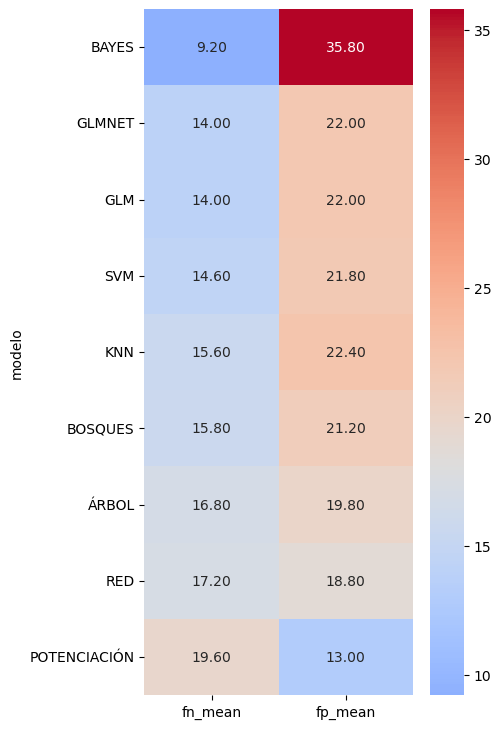

In [286]:
df_cm = confusion_matrix_cv_promedio(datos, df_seleccion, target_col="label", cv_splits=5)

# # 1) Curvas PR de todos los modelos en un solo gráfico
# pr_curves_all_models(
#     datos,
#     df_seleccion,
#     target_col="label",
#     cv_splits=5,
#     random_state=0
# )

# # 2) Interpretabilidad (Permutation Importance) con subplots
# permutation_importance_plot(
#     datos,
#     df_seleccion,
#     target_col="label",
#     cv_splits=5,
#     random_state=0,
#     n_repeats=10,
#     top_k=15
# )

# 3) Heatmap compacto FN/FP para el paper
heatmap_fn_fp(df_rank_cv)




## PR Curve

In [287]:
# Helpers para PR curves: _get_pr_curve_mean y _plot_pr_model
def _get_pr_curve_mean(row, X, y, cv, reg, target_col="label"):
    """
    Devuelve (mean_rec, mean_prec, mean_ap) promediados sobre folds para un modelo.
    """
    name = row["modelo"]
    best_params = row.get("best_params", None)

    estimator = reg[name]["estimator"]
    need_dense = reg[name]["need_dense"]

    all_prec = []
    all_rec = []
    ap_scores = []

    for tr_idx, te_idx in cv.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        datos_tr = X_tr.copy()
        datos_tr[target_col] = y_tr.values
        preprocessing = build_preprocessing(datos_tr, target_col=target_col)

        pipe = build_pipeline(preprocessing, estimator, need_dense)
        if isinstance(best_params, dict) and len(best_params) > 0:
            pipe = pipe.set_params(**sanitize_params(name, best_params))

        pipe.fit(X_tr, y_tr)

        scores = _get_scores(pipe, X_te)
        prec, rec, _ = precision_recall_curve(y_te, scores)
        ap = average_precision_score(y_te, scores)

        all_prec.append(prec)
        all_rec.append(rec)
        ap_scores.append(ap)

    # Interpolar en una grilla común y promediar
    grid = np.linspace(0, 1, 200)
    interp_prec = []
    for rec, prec in zip(all_rec, all_prec):
        interp_prec.append(np.interp(grid, rec[::-1], prec[::-1]))

    mean_prec = np.mean(interp_prec, axis=0)
    mean_rec = grid
    mean_ap = np.mean(ap_scores) if len(ap_scores) > 0 else np.nan

    return mean_rec, mean_prec, mean_ap


def _plot_pr_model(row, X, y, cv, reg, target_col="label", color="C0", lw=2, alpha=1.0, label=False):
    mean_rec, mean_prec, mean_ap = _get_pr_curve_mean(row, X, y, cv, reg, target_col)
    name = row["modelo"]
    lbl = f"{name} (AP={mean_ap:.3f})" if label else None
    plt.plot(mean_rec, mean_prec, color=color, lw=lw, alpha=alpha, label=lbl)


# top curvas PR (CV)
def pr_curves_topN(
    datos, df_seleccion, top_n=3, target_col="label", cv_splits=5, random_state=0
):
    df_top = df_seleccion.head(top_n)
    df_rest = df_seleccion.iloc[top_n:]

    X = datos.drop(columns=[target_col])
    y = datos[target_col]
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    reg = model_registry(random_state=random_state)

    plt.figure(figsize=(7,5))

    # resto en gris
    for _, row in df_rest.iterrows():
        _plot_pr_model(row, X, y, cv, reg, target_col, color="lightgray", lw=1, alpha=0.5)

    # top N en color
    colors = ["C0", "C1", "C2", "C3"]
    for i, (_, row) in enumerate(df_top.iterrows()):
        _plot_pr_model(row, X, y, cv, reg, target_col, color=colors[i % len(colors)], lw=2, alpha=1.0, label=True)

    plt.xlabel("Recall"); plt.ylabel("Precision")
    #plt.title("PR Curves (CV) - Top modelos vs resto")
    plt.legend()
    plt.grid(True)
    plt.savefig("pr_curves_topN.png", dpi=300, bbox_inches='tight')
    plt.show()


def pr_curves_small_multiples(datos, df_seleccion, target_col="label", cv_splits=5, random_state=0):
    X = datos.drop(columns=[target_col])
    y = datos[target_col]
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    reg = model_registry(random_state=random_state)

    n = len(df_seleccion)
    fig, axes = plt.subplots(n, 1, figsize=(6, 3*n), sharex=True, sharey=True)
    if n == 1: axes = [axes]

    for ax, (_, row) in zip(axes, df_seleccion.iterrows()):
        name = row["modelo"]
        mean_rec, mean_prec, mean_ap = _get_pr_curve_mean(row, X, y, cv, reg, target_col)
        ax.plot(mean_rec, mean_prec, lw=2)
        ax.set_title(f"{name} (AP={mean_ap:.3f})")
        ax.grid(True)

    axes[-1].set_xlabel("Recall")
    axes[len(axes)//2].set_ylabel("Precision")
    plt.tight_layout()
    plt.show()


In [ ]:


def _get_scores(estimator, X):
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
        s_min, s_max = s.min(), s.max()
        return (s - s_min) / (s_max - s_min + 1e-9)
    raise ValueError("Estimator sin predict_proba ni decision_function")

def pr_curve_modelo_ganador(
    datos,
    df_seleccion,
    target_col="label",
    cv_splits=5,
    random_state=0
):
    # toma el primer modelo de df_seleccion como ganador
    row = df_seleccion.iloc[0]
    name = row["modelo"]
    best_params = row.get("best_params", None)

    X = datos.drop(columns=[target_col])
    y = datos[target_col]

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    reg = model_registry(random_state=random_state)

    estimator = reg[name]["estimator"]
    need_dense = reg[name]["need_dense"]

    all_prec = []
    all_rec = []
    ap_scores = []

    for tr_idx, te_idx in cv.split(X, y):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        datos_tr = X_tr.copy()
        datos_tr[target_col] = y_tr.values
        preprocessing = build_preprocessing(datos_tr, target_col=target_col)

        pipe = build_pipeline(preprocessing, estimator, need_dense)
        if isinstance(best_params, dict) and len(best_params) > 0:
            pipe = pipe.set_params(**sanitize_params(name, best_params))

        pipe.fit(X_tr, y_tr)
        scores = _get_scores(pipe, X_te)

        prec, rec, _ = precision_recall_curve(y_te, scores)
        ap = average_precision_score(y_te, scores)

        all_prec.append(prec)
        all_rec.append(rec)
        ap_scores.append(ap)

    grid = np.linspace(0, 1, 200)
    interp_prec = []
    for rec, prec in zip(all_rec, all_prec):
        interp_prec.append(np.interp(grid, rec[::-1], prec[::-1]))

    mean_prec = np.mean(interp_prec, axis=0)
    std_prec = np.std(interp_prec, axis=0)
    mean_ap = np.mean(ap_scores)
    std_ap = np.std(ap_scores)

    plt.figure(figsize=(6.5, 4.0))
    plt.plot(grid, mean_prec, lw=2, label=f"{name} (AP={mean_ap:.3f}±{std_ap:.3f})")
    plt.fill_between(grid, mean_prec - std_prec, mean_prec + std_prec, alpha=0.2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    #plt.title("PR Curve (CV) - Modelo Ganador")
    plt.legend()
    plt.grid(True)
    plt.show()


In [270]:
def heatmap_importance(results_importance, top_k=12):
    # results_importance: dict {modelo: dataframe(feature, importance_mean)}
    # 1) escoger features globales top_k por promedio
    all_feats = pd.concat([
        df[["feature", "importance_mean"]].assign(modelo=m)
        for m, df in results_importance.items()
    ])
    top_feats = (all_feats.groupby("feature")["importance_mean"].mean()
                 .sort_values(ascending=False).head(top_k).index)

    # 2) construir matriz
    mat = []
    models = []
    for m, df in results_importance.items():
        row = df.set_index("feature").reindex(top_feats)["importance_mean"].fillna(0)
        mat.append(row.values)
        models.append(m)

    mat = pd.DataFrame(mat, index=models, columns=top_feats)

    plt.figure(figsize=(8, 0.6*len(models)+2))
    sns.heatmap(mat, annot=True, fmt=".3f", cmap="Blues")
    plt.title("Permutation Importance (mean) - modelos")
    plt.show()


c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\josep\anaconda3\Lib\site-packages\sklearn\neural_network\_multi

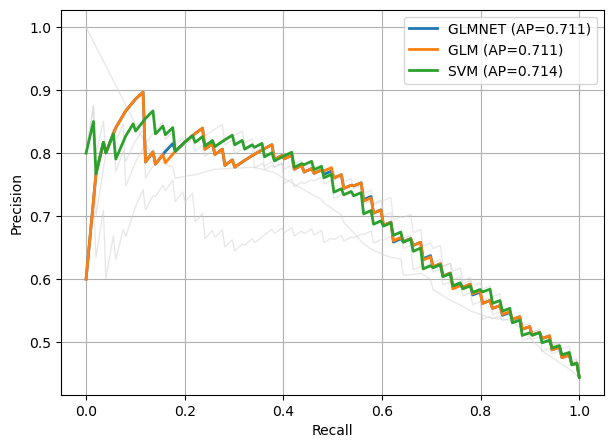

In [288]:
# =========================
# USO: Curvas PR (todas las alternativas)
# =========================

# A) Top-N en color + resto en gris
pr_curves_topN(
    datos,
    df_seleccion,
    top_n=3,
    target_col="label",
    cv_splits=5,
    random_state=0
)

# B) Small multiples (una curva por modelo)
# pr_curves_small_multiples(
#     datos,
#     df_seleccion,
#     target_col="label",
#     cv_splits=5,
#     random_state=0
# )

# C) Todas en un solo gráfico (si quieres comparar rápido)
# pr_curves_all_models(
#     datos,
#     df_seleccion,
#     target_col="label",
#     cv_splits=5,
#     random_state=0
# )

# pr_curve_modelo_ganador(
#     datos,
#     df_seleccion,
#     target_col="label",
#     cv_splits=5,
#     random_state=0
# )


# =========================
# USO: Interpretabilidad (todas las alternativas)
# =========================

# # 1) Barras por modelo (subplots)
# permutation_importance_plot(
#     datos,
#     df_seleccion,
#     target_col="label",
#     cv_splits=5,
#     random_state=0,
#     n_repeats=10,
#     top_k=15
# )

# 2) Heatmap compacto de importancia
# (usa el dict de resultados de permutation_importance_cv)
# imp_results = permutation_importance_cv(
#     datos,
#     df_seleccion,
#     target_col="label",
#     cv_splits=5,
#     random_state=0,
#     n_repeats=10
# )

# heatmap_importance(
#     imp_results,
#     top_k=12
# )


## Coeficientes estandarizados

In [ ]:

def coeficientes_estandarizados(modelo_final, datos, target_col="label"):
    """
    Extrae coeficientes estandarizados del pipeline entrenado (GLM/GLMNET).
    Asume que el pipeline incluye StandardScaler en numéricas.
    """
    # 1) obtener nombres de features después del preprocesamiento
    pre = modelo_final.named_steps["preprocessor"]
    try:
        feature_names = pre.get_feature_names_out()
    except Exception:
        # fallback: intenta construir nombres manualmente
        feature_names = []
        for name, trans, cols in pre.transformers_:
            if hasattr(trans, "get_feature_names_out"):
                feature_names.extend(trans.get_feature_names_out(cols))
            else:
                feature_names.extend(cols)

    # 2) coeficientes del modelo
    model = modelo_final.named_steps["model"]
    coef = model.coef_.ravel()

    # 3) dataframe ordenado
    df_coef = pd.DataFrame({
        "feature": feature_names,
        "coef_std": coef,
        "abs_coef_std": np.abs(coef)
    }).sort_values("abs_coef_std", ascending=False)

    return df_coef

# USO:
df_coef = coeficientes_estandarizados(modelo_final, datos, target_col="label")
print(df_coef.head(20).to_string(index=False))


           feature  coef_std  abs_coef_std
         num__tcwv  1.512212      1.512212
         num__t500 -1.181923      1.181923
    num__rh600_700 -0.546243      0.546243
num__shear_200_850 -0.516669      0.516669
     num__mslp_hpa -0.422357      0.422357
        num__sst_c  0.404557      0.404557
         num__v850 -0.251690      0.251690
         num__u200 -0.250956      0.250956
         num__v200 -0.195319      0.195319
        num__romi1  0.134251      0.134251
  num__nino34_anom -0.123214      0.123214
     num__qbo_30mb -0.071565      0.071565
         num__u850  0.042918      0.042918
        num__romi2  0.030758      0.030758
    num__nao_index -0.026029      0.026029
     num__amo_ssta  0.002548      0.002548


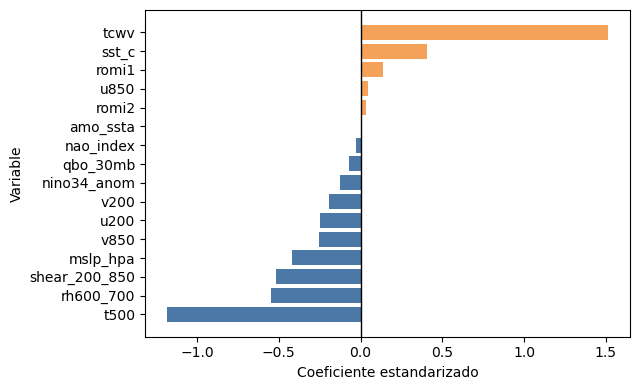

In [ ]:


def plot_coef_top(df_coef, top_k=10):
    """
    Gráfico de barras con signos (+/-) para los coeficientes estandarizados.
    Quita el prefijo 'num__' en las etiquetas.
    """
    df_top = df_coef.head(top_k).copy()
    df_top = df_top.sort_values("coef_std")

    # quitar prefijo num__
    df_top["feature"] = df_top["feature"].str.replace("num__", "", regex=False)

    # tonos anteriores: azul para negativo, naranja para positivo
    colors = ["#4c78a8" if v < 0 else "#f4a259" for v in df_top["coef_std"]]

    plt.figure(figsize=(6.5, 4.0))
    plt.barh(df_top["feature"], df_top["coef_std"], color=colors, edgecolor="none")
    plt.axvline(0, color="black", lw=1)
    #plt.title("Top coeficientes estandarizados (GLMNET)")
    plt.xlabel("Coeficiente estandarizado")
    plt.ylabel("Variable")
    plt.tight_layout()
    plt.savefig("coeficientes_estandarizados.png", dpi=300, bbox_inches='tight')
    plt.show()

# USO:
df_coef = coeficientes_estandarizados(modelo_final, datos, target_col="label")
plot_coef_top(df_coef, top_k=20)




In [266]:
# import os
# os.chdir(r"E:\PROMIDAT\Maestria\Proyecto\project\data\processed")
# datos = pd.read_csv("dataset_final_completo - copia.csv", delimiter = ',', decimal = ".",index_col=0)

# datos.drop(columns=["year", "month", "day","hour","lat","lon"], inplace=True)

# datos

In [267]:
# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# import numpy as np

# def sfs_feature_selection(datos, target_col="label", k=5, random_state=0, n_features=10):
#     X = datos.drop(columns=[target_col])
#     y = datos[target_col]

#     # Modelo base (ej. GLMNET)
#     model = LogisticRegression(
#         penalty="elasticnet",
#         solver="saga",
#         l1_ratio=0.5,
#         C=1.0,
#         max_iter=2000
#     )

#     cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)
#     scorer_f2 = make_scorer(fbeta_score, beta=2, pos_label=1, zero_division=0)

#     sfs = SequentialFeatureSelector(
#     model,
#     n_features_to_select=n_features,
#     direction="forward",
#     scoring=scorer_f2,  # prioriza FN
#     cv=cv,
#     n_jobs=-1
# )
#     sfs.fit(X, y)

#     selected = X.columns[sfs.get_support()].tolist()
#     return selected

# # USO
# best_feats = sfs_feature_selection(datos, target_col="label", k=5, n_features=10)
# print(best_feats)
